<font size = 8> **Load Forecasting with Weather Data** <font>

**Contributors**: Arundati Kolahal, Barrett Ratzlaff, Shreya Lodha, Tharfeed Ahmed Unus

https://colab.research.google.com/drive/169iC8UVE-qL8vj9063Fm-0WMAmqbMHme?usp=sharing

# **Problem Statement**

Understanding the expected amount of electricity consumed is an important piece of effectively delivering electricity to the grid. If too much is sent, grid overload can occur and leave a negative impact on the environment. Too little electricity can lead to inconsistent service for customers.

Our project is aimed at finding a simple way to reasonably predict the amount of electricity a subset of the grid will use. Through simple regression models, electricity consumption can be predicted and providers can appropriately prepare and adjust their delivery of the service. This is not only useful for service providers, but also consumers who might want to estimate costs.

# **Dataset Info**
The dataset we use in this project is publicly available and contains 8 years worth of hourly data on the electricity and heat consumption of a residential building. Additionally, weather data is included for the building's location. The location is not disclosed. However, because temperatures are higher at the beginning and end of the year while being lower in the middle of the year, it can be safely assumed that the building is in the Southern Hemisphere.

https://data.mendeley.com/datasets/fb7x34b7zs/1

# **Data Exploration and Cleaning**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://drive.google.com/uc?export=download&id=1b1h0-fMTRolEz9aRkSNRVMpiBWdhlrr6'

power = pd.read_csv(file_url)

In [ ]:
power.head()

Time  air_pressure[mmHg]  air_temperature[degree celcius]  \
0  2010-12-01 00:00:00               729.7                             25.0   
1  2010-12-01 01:00:00               729.4                             27.8   
2  2010-12-01 02:00:00               728.9                             33.3   
3  2010-12-01 03:00:00               731.6                             32.2   
4  2010-12-01 04:00:00               732.6                             22.8   

   relative_humidity[%]  wind_speed[M/S]  solar_irridiation[W/m²]  \
0                  85.0              5.0                        0   
1                  77.0              7.0                        0   
2                  62.0              7.0                        0   
3                  62.0              2.0                        0   
4                  96.0              3.0                        0   

  total_cloud_cover[from ten]  electricity_demand_values[kw]  \
0                   no clouds                     289.567557   
1                   no clouds                     260.168520   
2                  2/10–3/10.                     247.273585   
3                       5/10.                     257.955878   
4                  2/10–3/10.                     258.255081   

   heat_demand_values[kw]  
0              432.940036  
1              473.935901  
2              483.278761  
3              545.921252  
4              550.526112

In [ ]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             70080 non-null  object 
 1   air_pressure[mmHg]               69934 non-null  float64
 2   air_temperature[degree celcius]  69903 non-null  float64
 3   relative_humidity[%]             69903 non-null  float64
 4   wind_speed[M/S]                  69125 non-null  float64
 5   solar_irridiation[W/m²]          70080 non-null  int64  
 6   total_cloud_cover[from ten]      69837 non-null  object 
 7   electricity_demand_values[kw]    70073 non-null  float64
 8   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 4.8+ MB


Thankfully, the amount of null values are manageable. Because electricity_demand_values[kW] is our target variable, we remove the 7 rows where no value is recorded. The other columns will be handled in our pipeline.

In [ ]:
power = power.dropna(subset=['electricity_demand_values[kw]'])

In [ ]:
power.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70073 entries, 0 to 70079
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             70073 non-null  object 
 1   air_pressure[mmHg]               69927 non-null  float64
 2   air_temperature[degree celcius]  69896 non-null  float64
 3   relative_humidity[%]             69896 non-null  float64
 4   wind_speed[M/S]                  69118 non-null  float64
 5   solar_irridiation[W/m²]          70073 non-null  int64  
 6   total_cloud_cover[from ten]      69830 non-null  object 
 7   electricity_demand_values[kw]    70073 non-null  float64
 8   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 5.3+ MB


In order for our machine learning models to give stronger predictions, we will feature engineer several columns based on pre-existing data.

For example, perhaps weekends have an impact on electricity consumption that is different than weekdays. We'll create a categorical variable that indicates whether a day is a weekend or not.

In [ ]:
power["Time"] = pd.to_datetime(power["Time"])

power["is_weekend"] = power["Time"].dt.weekday >= 5 # weekday is zero-indexed, five is saturday, not friday.

In [ ]:
power["is_weekend"].value_counts()

is_weekend
False    50059
True     20014
Name: count, dtype: int64

Next, we create a column that indicates whether or not an hour is a "peak hour". A peak hour is defined as a time when people tend to use electricity more. According to various sources based out of the Southern Hemisphere, peak hours of consumption can be considered anywhere 2 p.m. to 8 p.m. *or* 4 p.m. to 9 p.m. https://www.abc.net.au/news/2022-06-20/what-is-off-peak-electricity-what-hours/101166920

For our purposes, we will define 2 p.m. to 9 p.m. as peak hours for our dataset.

In [ ]:
power["peak_hour"] = (power["Time"].dt.hour >=14) & (power["Time"].dt.hour <=21)

We also want our model to consider whether it is day or night time. We use 6 a.m. - 6 p.m. as a stand-in for daytime.

In [ ]:
power["day_time"] = (power["Time"].dt.hour >=6) & (power["Time"].dt.hour <=18)

Another variable that can be considered is the dew point, a different metric for humidity.

The dew point is the temperature must be cooled to in order to be saturated with water vapor. The closer the dew point is to the temperature, the more humid it will feel.

We suspect this may have an impact on use of air conditioning, and in turn use of electricity. Below is the formula for the dew point being inserted into our table.

In [ ]:
power["dew_point"] = power["air_temperature[degree celcius]"] - ((100 - power["relative_humidity[%]"]) / 5)

After research, we found that some Utility companies use [lagging values](https://insidelines.pjm.com/pjm-publishes-2024-long-term-load-forecast/) to [predict](https://www.ibm.com/topics/load-forecasting#:~:text=Long%2Dterm%20load%20forecasting&text=This%20includes%20data%20from%20the,population%20density%2C%20economic%20activity) electricity consumption. The following code appends the electricity consumption from 24 hours before the recorded row to the DataFrame.

Then, we remove the day with null values in the new feature (24 rows).

In [ ]:
consumption_24 = []
for index, rows in power.iterrows():
  if index - 24 in power.index:
    consumption_24.append(power.loc[index - 24, "electricity_demand_values[kw]"])
  else:
    consumption_24.append(None)
print(consumption_24[0:30])
power.head(5)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 289.56755652737, 260.16852029539007, 247.27358490458, 257.95587769177, 258.25508122726995, 277.57748106862994]


Time  air_pressure[mmHg]  air_temperature[degree celcius]  \
0 2010-12-01 00:00:00               729.7                             25.0   
1 2010-12-01 01:00:00               729.4                             27.8   
2 2010-12-01 02:00:00               728.9                             33.3   
3 2010-12-01 03:00:00               731.6                             32.2   
4 2010-12-01 04:00:00               732.6                             22.8   

   relative_humidity[%]  wind_speed[M/S]  solar_irridiation[W/m²]  \
0                  85.0              5.0                        0   
1                  77.0              7.0                        0   
2                  62.0              7.0                        0   
3                  62.0              2.0                        0   
4                  96.0              3.0                        0   

  total_cloud_cover[from ten]  electricity_demand_values[kw]  \
0                   no clouds                     289.567557   
1                   no clouds                     260.168520   
2                  2/10–3/10.                     247.273585   
3                       5/10.                     257.955878   
4                  2/10–3/10.                     258.255081   

   heat_demand_values[kw]  is_weekend  peak_hour  day_time  dew_point  
0              432.940036       False      False     False       22.0  
1              473.935901       False      False     False       23.2  
2              483.278761       False      False     False       25.7  
3              545.921252       False      False     False       24.6  
4              550.526112       False      False     False       22.0

In [ ]:
power['consumption_24'] = consumption_24
power = power.dropna(subset=['consumption_24'])

Lastly, we create categorical variables indicating what season the row is in. We anticipate that consumption patterns change by season.

In [ ]:
power["summer"] = power["Time"].dt.month < 4
power["autumn"] = (power["Time"].dt.month >=4) & (power["Time"].dt.month <=6)
power["winter"] = (power["Time"].dt.month >=7) & (power["Time"].dt.month <=9)
power["spring"] = (power["Time"].dt.month >=10) & (power["Time"].dt.month <=12)

<ipython-input-13-ba9bb9c3402a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power["summer"] = power["Time"].dt.month < 4
<ipython-input-13-ba9bb9c3402a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power["autumn"] = (power["Time"].dt.month >=4) & (power["Time"].dt.month <=6)
<ipython-input-13-ba9bb9c3402a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Now that we have engineered potentially important features from out data and  don't plan to use the specific hourly timestamp in our modeling, we set it as the index of our dataset. Separately, it will also allow us to plot time-series data. This should give us a clearer picture of consumption patterns before we begin modeling.

In [ ]:
power.set_index("Time", inplace=True)

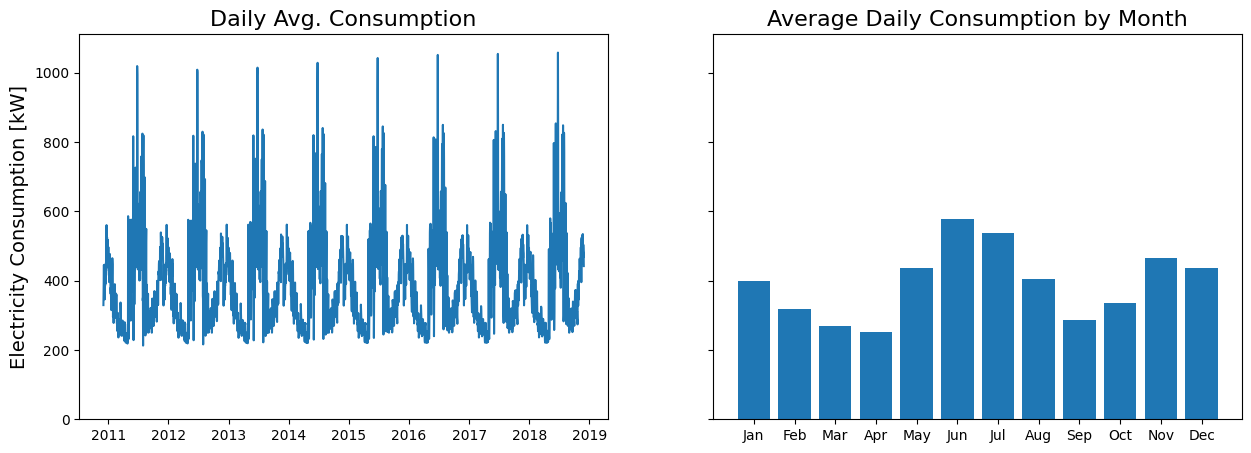

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
power_month = power["electricity_demand_values[kw]"].resample('ME').mean()
power_daily = power["electricity_demand_values[kw]"].resample('D').mean()

power2 = power.copy()
power2['month'] = power2.index.month
avg_monthly_consumption = power2.groupby('month')["electricity_demand_values[kw]"].mean()
avg_monthly_consumption

ax[0].plot(power_daily.index, power_daily)
ax[0].set_title("Daily Avg. Consumption", fontsize=16)

ax[1].bar(avg_monthly_consumption.index, avg_monthly_consumption)
ax[1].set_title("Average Daily Consumption by Month", fontsize=16)
ax[1].set_xticks(range(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax[0].set_ylabel("Electricity Consumption [kW]", fontsize=14)
plt.show()

As expected, electricity consumption fluctuates based on the time. This may limit the use of a simple linear regression model. Consumption spikes about halfway through each year, which coincides with the Southern Hemisphere's summer.

Further manipulation is needed for the column for cloud cover, which is initially listed as various strings. We convert them to floats on a scale from 0 to 1 so it can be listed as a proportion.

In [ ]:
power["total_cloud_cover[from ten]"].unique()

array(['no clouds', '2/10–3/10.', '5/10.', '7/10 – 8/10.', '10/10.',
       'Sky obscured by fog and/or other meteorological phenomena.', nan,
       '4/10.'], dtype=object)

In [ ]:
power["total_cloud_cover[from ten]"] = power["total_cloud_cover[from ten]"].replace({'no clouds': 0,
                                                                                     '2/10–3/10.':.25,
                                                                                     '4/10.':.4,
                                                                                     '5/10.':.5,
                                                                                     '7/10 – 8/10.':.75,
                                                                                     '10/10.':1,
                                                                                     'Sky obscured by fog and/or other meteorological phenomena.':1})
power["total_cloud_cover[from ten]"].unique()

<ipython-input-17-396d9fad0dc6>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power["total_cloud_cover[from ten]"] = power["total_cloud_cover[from ten]"].replace({'no clouds': 0,


array([0.  , 0.25, 0.5 , 0.75, 1.  ,  nan, 0.4 ])

Now that the data has been supplemented and adjusted, we look at the relationships between variables.

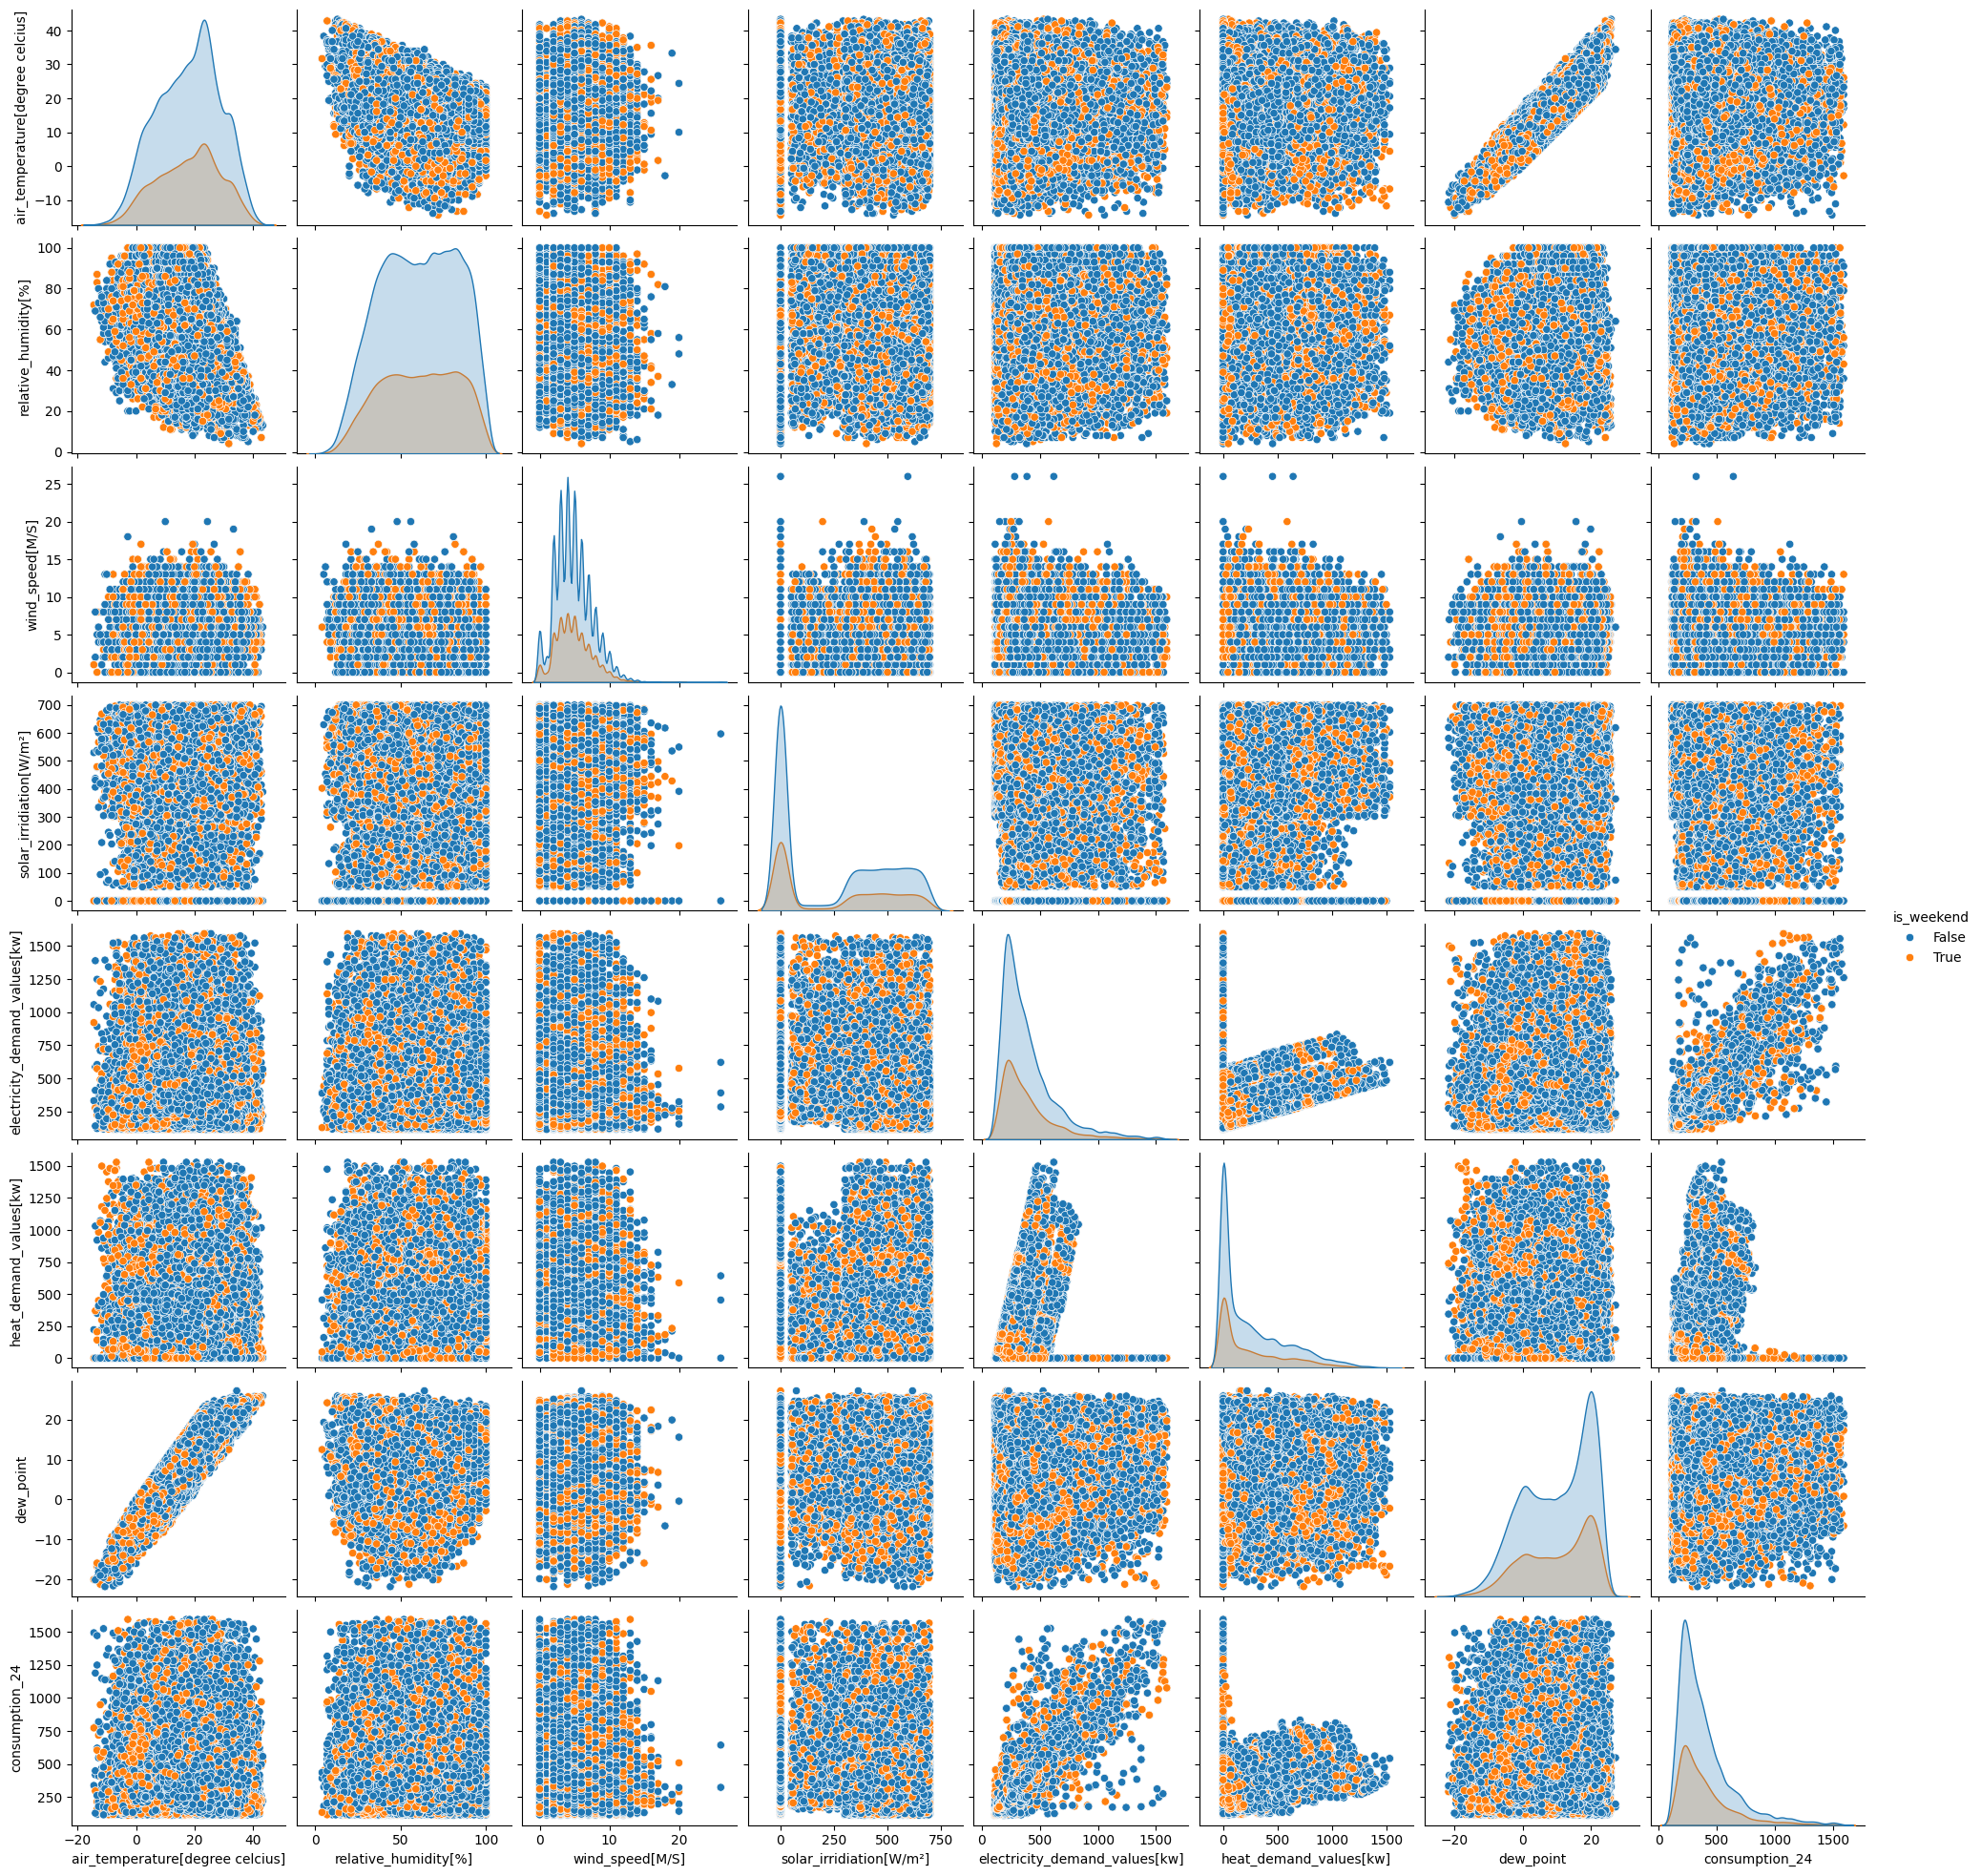

In [ ]:
sns.pairplot(power.drop(columns=["autumn","spring","winter","summer","peak_hour",
                                "total_cloud_cover[from ten]","air_pressure[mmHg]",'day_time']), hue = 'is_weekend')

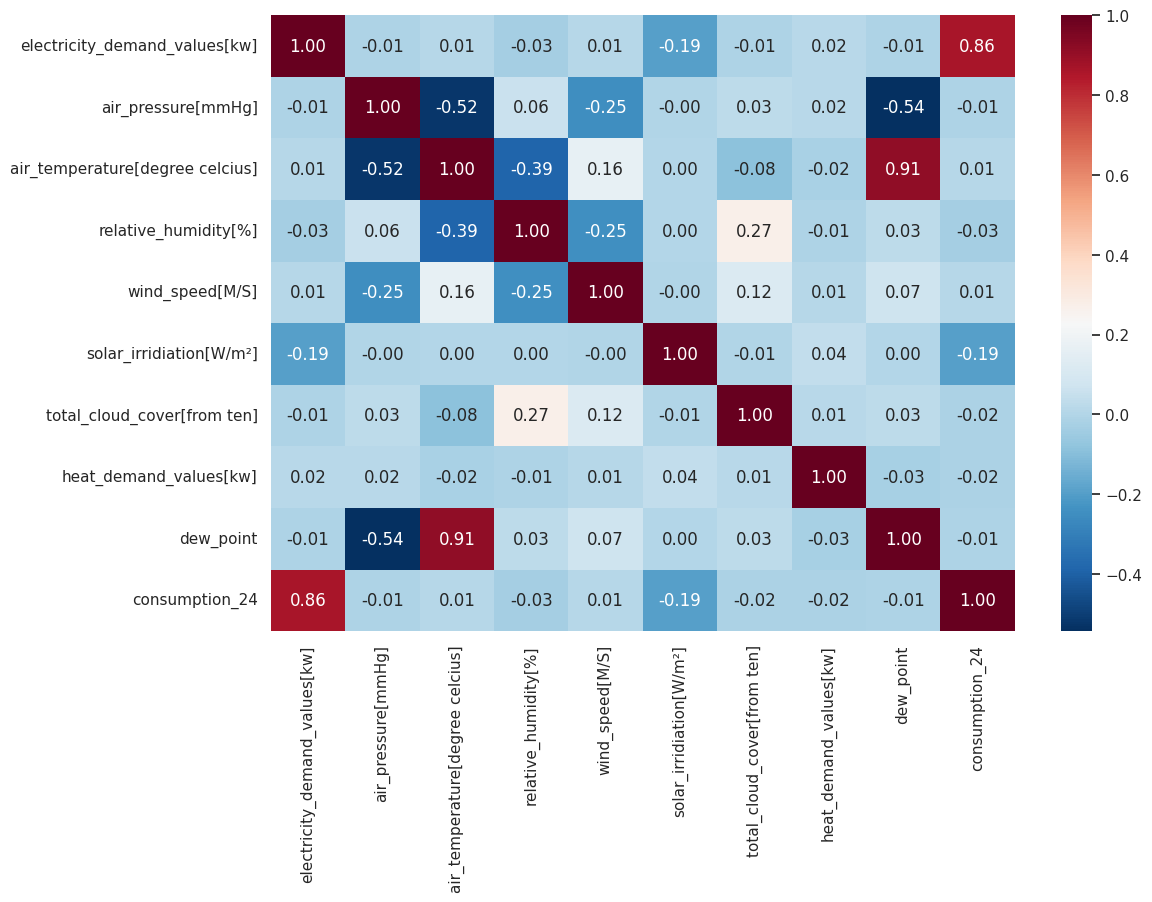

In [ ]:
corr_matrix = power[['electricity_demand_values[kw]', 'air_pressure[mmHg]', 'air_temperature[degree celcius]',
                     'relative_humidity[%]', 'wind_speed[M/S]', 'solar_irridiation[W/m²]', 'total_cloud_cover[from ten]',
                     'heat_demand_values[kw]', 'dew_point','consumption_24']].corr(numeric_only=True)
sns.set_theme(rc={'figure.figsize':(12, 8)})
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r');

Aside from our feature detailing previous values of electricity consumption, the only other feature with a notable correlation with our target variable happens to be solar irradiation.

This could be because people tend to use more electricity during the evening at peak hours.

Now we can turn our attention to splitting and preprocessing.

# **Splitting and Preprocessing**

In [ ]:
#electricity_demand_values[kw]
from sklearn.model_selection import train_test_split

X = power.drop(["electricity_demand_values[kw]","heat_demand_values[kw]"], axis=1)
y = power["electricity_demand_values[kw]"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_train

air_pressure[mmHg]  air_temperature[degree celcius]  \
Time                                                                       
2014-12-27 12:00:00               733.8                             37.2   
2016-03-20 20:00:00               732.6                             22.2   
2016-05-07 04:00:00               733.1                             31.7   
2015-10-20 10:00:00               735.4                             21.1   
2016-04-12 03:00:00               730.6                             16.1   
...                                 ...                              ...   
2015-03-01 02:00:00               734.2                             23.9   
2011-08-20 01:00:00               738.3                             22.2   
2017-03-07 10:00:00               734.5                             30.0   
2011-01-06 20:00:00               730.6                             10.0   
2012-09-20 05:00:00               732.1                             30.0   

                     relative_humidity[%]  wind_speed[M/S]  \
Time                                                         
2014-12-27 12:00:00                  23.0              5.0   
2016-03-20 20:00:00                  50.0              3.0   
2016-05-07 04:00:00                  41.0              2.0   
2015-10-20 10:00:00                  90.0              2.0   
2016-04-12 03:00:00                  84.0              7.0   
...                                   ...              ...   
2015-03-01 02:00:00                  62.0              5.0   
2011-08-20 01:00:00                  22.0              8.0   
2017-03-07 10:00:00                  48.0              5.0   
2011-01-06 20:00:00                 100.0              2.0   
2012-09-20 05:00:00                  36.0              7.0   

                     solar_irridiation[W/m²]  total_cloud_cover[from ten]  \
Time                                                                        
2014-12-27 12:00:00                      305                         0.00   
2016-03-20 20:00:00                        0                         0.00   
2016-05-07 04:00:00                        0                         0.50   
2015-10-20 10:00:00                      529                         0.75   
2016-04-12 03:00:00                        0                         0.00   
...                                      ...                          ...   
2015-03-01 02:00:00                        0                         0.75   
2011-08-20 01:00:00                        0                         0.00   
2017-03-07 10:00:00                      549                         0.00   
2011-01-06 20:00:00                        0                         1.00   
2012-09-20 05:00:00                        0                         1.00   

                     is_weekend  peak_hour  day_time  dew_point  \
Time                                                              
2014-12-27 12:00:00        True      False      True       21.8   
2016-03-20 20:00:00        True       True     False       12.2   
2016-05-07 04:00:00        True      False     False       19.9   
2015-10-20 10:00:00       False      False      True       19.1   
2016-04-12 03:00:00       False      False     False       12.9   
...                         ...        ...       ...        ...   
2015-03-01 02:00:00        True      False     False       16.3   
2011-08-20 01:00:00        True      False     False        6.6   
2017-03-07 10:00:00       False      False      True       19.6   
2011-01-06 20:00:00       False       True     False       10.0   
2012-09-20 05:00:00       False      False     False       17.2   

                     consumption_24  summer  autumn  winter  spring  
Time                                                                 
2014-12-27 12:00:00      538.590475   False   False   False    True  
2016-03-20 20:00:00      221.064940    True   False   False   False  
2016-05-07 04:00:00      242.481035   False    True   False   False  
2

Which columns have null values?

In [ ]:
cols = ['air_pressure[mmHg]', 'air_temperature[degree celcius]', 'relative_humidity[%]', 'wind_speed[M/S]',
        'solar_irridiation[W/m²]', 'total_cloud_cover[from ten]', 'electricity_demand_values[kw]',
        'heat_demand_values[kw]','day_time','is_weekend', 'peak_hour', 'consumption_24',
        'dew_point', 'summer', 'autumn', 'winter', 'spring']

for i in cols:
  print(i, power[i].isna().sum())

air_pressure[mmHg] 146
air_temperature[degree celcius] 177
relative_humidity[%] 177
wind_speed[M/S] 955
solar_irridiation[W/m²] 0
total_cloud_cover[from ten] 243
electricity_demand_values[kw] 0
heat_demand_values[kw] 0
day_time 0
is_weekend 0
peak_hour 0
consumption_24 0
dew_point 177
summer 0
autumn 0
winter 0
spring 0


Wind speed has a significant number of null values, with a few other features sitting at ~100-200 null values. Our pipeline will address this.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse_output=False))
    ])

cats = ['is_weekend','peak_hour','summer','autumn','winter','spring','day_time']
nums = ['air_pressure[mmHg]','air_temperature[degree celcius]','relative_humidity[%]','wind_speed[M/S]','solar_irridiation[W/m²]',
        'total_cloud_cover[from ten]','dew_point','consumption_24']
prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, nums),
    ('cat', cat_pipeline, cats)
], verbose_feature_names_out=False)
prep_pipeline.set_output(transform='pandas') # output as a pandas dataframe instead of numpy array

# This will be used in the Decision Tree/Random Forest section.
X_train_prepd = prep_pipeline.fit_transform(X_train)
X_test_prepd = prep_pipeline.transform(X_test)


We create an X_train and X_test that is pre-processed because we found our code was easier to execute in the Decision Tree and Random Forest section with pre-processed data.

We begin our modelling with Linear Regression.

# **Model Selection**

## **Linear Regression**

### Simple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

lin_reg = Pipeline([('prepare',prep_pipeline), ('regression',LinearRegression())])
lin_reg.fit(X_train, y_train)
lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f'Training Linear Regression RMSE: {(-lin_reg_scores).mean()}')
lin_reg_r2 = cross_val_score(lin_reg, X_train, y_train, scoring = "r2", cv=3)
print(f'Training Linear Regression R2: {(lin_reg_r2).mean()}')

Linear Regression RMSE: 120.08998722586425
Linear Regression R2: 0.7479359130862161
Target Variable Training Std. Deviation: 239.23424335471702


The linear regression model thankfully does much better than if we were to just predict the mean for every row, with an RMSE of ~120.

 Next, let's try to raise the degree of some variables and the Ridge model. Because any degree higher than 2 crashes our Colab, we skip a RandomizedSearch and settle with a degree of 2.


### Poly Linear Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
pn = PolynomialFeatures(degree=2)
pn_pipeline = Pipeline([('prep',prep_pipeline),('poly',pn),('regression',LinearRegression())])
pn_pipeline.fit(X_train, y_train)
pn_pipeline_scores = cross_val_score(pn_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f'Training Poly Linear Regression RMSE: {(-pn_pipeline_scores).mean()}')
poly_lin_reg_r2 = cross_val_score(pn_pipeline, X_train, y_train, scoring = "r2", cv=3)
print(f'Training Poly Linear Regression R2: {(poly_lin_reg_r2).mean()}')
# print(f'Target Variable Training Std. Deviation: {y_train.std()}')

Poly Linear Regression RMSE: 118.09276381930333
Poly Linear Regression R2: 0.7562362476384106
Target Variable Training Std. Deviation: 239.23424335471702


A marginal improvement, but not by much. Now to try Ridge and Lasso, respectively.

### Ridge Regression and Poly Ridge Regression

In [ ]:
ridge_pipeline = Pipeline([('prep',prep_pipeline),('regression',Ridge(alpha=10))])
ridge_pn_pipeline = Pipeline([('prep',prep_pipeline),('poly',pn),('regression',Ridge(alpha=10))])

ridge_pipeline.fit(X_train, y_train)
ridge_pn_pipeline.fit(X_train, y_train)

rp_scores = cross_val_score(ridge_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
rp_pn_scores = cross_val_score(ridge_pn_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)

print(f'Training Ridge Regression RMSE: {(-rp_scores).mean()}')
print(f'Training Poly Ridge Regression RMSE: {(-rp_pn_scores).mean()}')

rp_reg_r2 = cross_val_score(ridge_pipeline, X_train, y_train, scoring = "r2", cv=3)
rp_pn_r2 = cross_val_score(ridge_pn_pipeline, X_train, y_train, scoring = "r2", cv=3)
print(f'Training Ridge Regression R2: {(rp_reg_r2).mean()}')
print(f'Training Poly Ridge Regression R2: {(rp_pn_r2).mean()}')

Ridge Regression RMSE: 120.09004307294772
Poly Ridge Regression RMSE: 118.09225489807271
Ridge Regression R2: 0.7479356702247305
Poly Ridge Regression R2: 0.7562387645015254


We see that the ridge regression slightly underperforms as compared to the poly linear regression. However, poly ridge regression does minutely better than poly linear regression. This isn't significant enough though, so we try to tune the hyper parameters to observe any significant change.

### Hyperparameter Tuning on Poly Ridge Regression using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'poly__degree':[1,2],
     'regression__alpha':[1, 5, 10, 25, 50, 100]}
]

grid_search = GridSearchCV(ridge_pn_pipeline, param_grid, cv=None, scoring='r2')
grid_search.fit(X_train, y_train)
gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.sort_values(by = 'rank_test_score', ascending = True, inplace=True)
gs_results[['param_poly__degree','param_regression__alpha','mean_test_score','rank_test_score']].head(5)

param_poly__degree  param_regression__alpha  mean_test_score  \
11                   2                      100         0.756530   
10                   2                       50         0.756526   
9                    2                       25         0.756523   
6                    2                        1         0.756523   
8                    2                       10         0.756522   

    rank_test_score  
11                1  
10                2  
9                 3  
6                 4  
8                 5

It seems that a degree of 2 and an alpha of 100 provides the best R2 score of the different possible parameters we provided in the grid, just over .756.

To see what our model values most highly, we check to see the which features have the highest coefficients.

In [ ]:
ridge_model = ridge_pipeline.named_steps['regression']
coefficients = ridge_model.coef_

feature_names = ridge_pipeline[:-1].get_feature_names_out()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                            Feature  Coefficient
7                    consumption_24   200.429391
21                    day_time_True   -11.706243
20                   day_time_False    11.706243
11                   peak_hour_True     9.622401
10                  peak_hour_False    -9.622401
12                     summer_False     6.298079
13                      summer_True    -6.298079
14                     autumn_False    -3.825624
15                      autumn_True     3.825624
18                     spring_False    -2.534647
19                      spring_True     2.534647
6                         dew_point    -1.837588
1   air_temperature[degree celcius]     1.755735
2              relative_humidity[%]     0.673460
5       total_cloud_cover[from ten]     0.671502
8                  is_weekend_False    -0.458948
9                   is_weekend_True     0.458948
3                   wind_speed[M/S]     0.424182
4           solar_irridiation[W/m²]     0.343170


The model finds the lagging consumption variable to be the most significant in determining the electricity output of the building.

While it is unlikely to have a significantly different result as we already have very few features, it is worth investigating how the lasso pipeline performs.

### Lasso Regression and Poly Lasso Regression

In [ ]:
lasso_pipeline = Pipeline([('prep',prep_pipeline),('regression',Lasso(alpha=1))])
lasso_pn_pipeline = Pipeline([('prep',prep_pipeline),('poly',pn),('regression',Lasso(alpha=1))])

lasso_pipeline.fit(X_train, y_train)
lasso_pn_pipeline.fit(X_train, y_train)

ls_scores = cross_val_score(lasso_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
ls_pn_scores = cross_val_score(lasso_pn_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)

print(f'Training Lasso Regression RMSE: {(-ls_scores).mean()}')
print(f'Training Poly Lasso Regression RMSE: {(-ls_pn_scores).mean()}')

ls_reg_r2 = cross_val_score(lasso_pipeline, X_train, y_train, scoring = "r2", cv=3)
ls_pn_r2 = cross_val_score(lasso_pn_pipeline, X_train, y_train, scoring = "r2", cv=3)
print(f'Training Lasso Regression R2: {(ls_reg_r2).mean()}')
print(f'Training Poly Lasso Regression R2: {(ls_pn_r2).mean()}')

Lasso Regression RMSE: 120.17601841353577
Poly Lasso Regression RMSE: 118.28309276640749
Lasso Regression R2: 0.7475762968419405
Poly Lasso Regression R2: 0.7554516035789026


No improvement, though Lasso does nearly as well as Ridge with Polynomial Features at a degree of 2.

In any case, using Lasso when our model is already underfitting is a bit redundant. To see if we can make improvements, we shift to Decision Trees.

## **Decision Trees**

### Decision Tree Regressor

[Text(0.5, 0.875, 'consumption_24 <= 0.5\nsquared_error = 57232.0\nsamples = 56033\nvalue = 393.8'),
 Text(0.25, 0.625, 'consumption_24 <= -0.4\nsquared_error = 15875.1\nsamples = 44202\nvalue = 303.7'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'consumption_24 <= -0.6\nsquared_error = 7747.0\nsamples = 25705\nvalue = 236.0'),
 Text(0.0625, 0.125, 'squared_error = 6304.5\nsamples = 15799\nvalue = 208.2'),
 Text(0.1875, 0.125, 'squared_error = 6849.6\nsamples = 9906\nvalue = 280.3'),
 Text(0.375, 0.375, 'consumption_24 <= 0.1\nsquared_error = 11957.7\nsamples = 18497\nvalue = 397.7'),
 Text(0.3125, 0.125, 'squared_error = 9119.4\nsamples = 12362\nvalue = 362.7'),
 Text(0.4375, 0.125, 'squared_error = 10227.8\nsamples = 6135\nvalue = 468.3'),
 Text(0.75, 0.625, 'consumption_24 <= 1.8\nsquared_error = 68142.8\nsamples = 11831\nvalue = 730.3'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'consumption_24 <= 1.1\nsquared_error = 28254.5\nsamples = 8214\nvalue = 634.4'),
 Text(

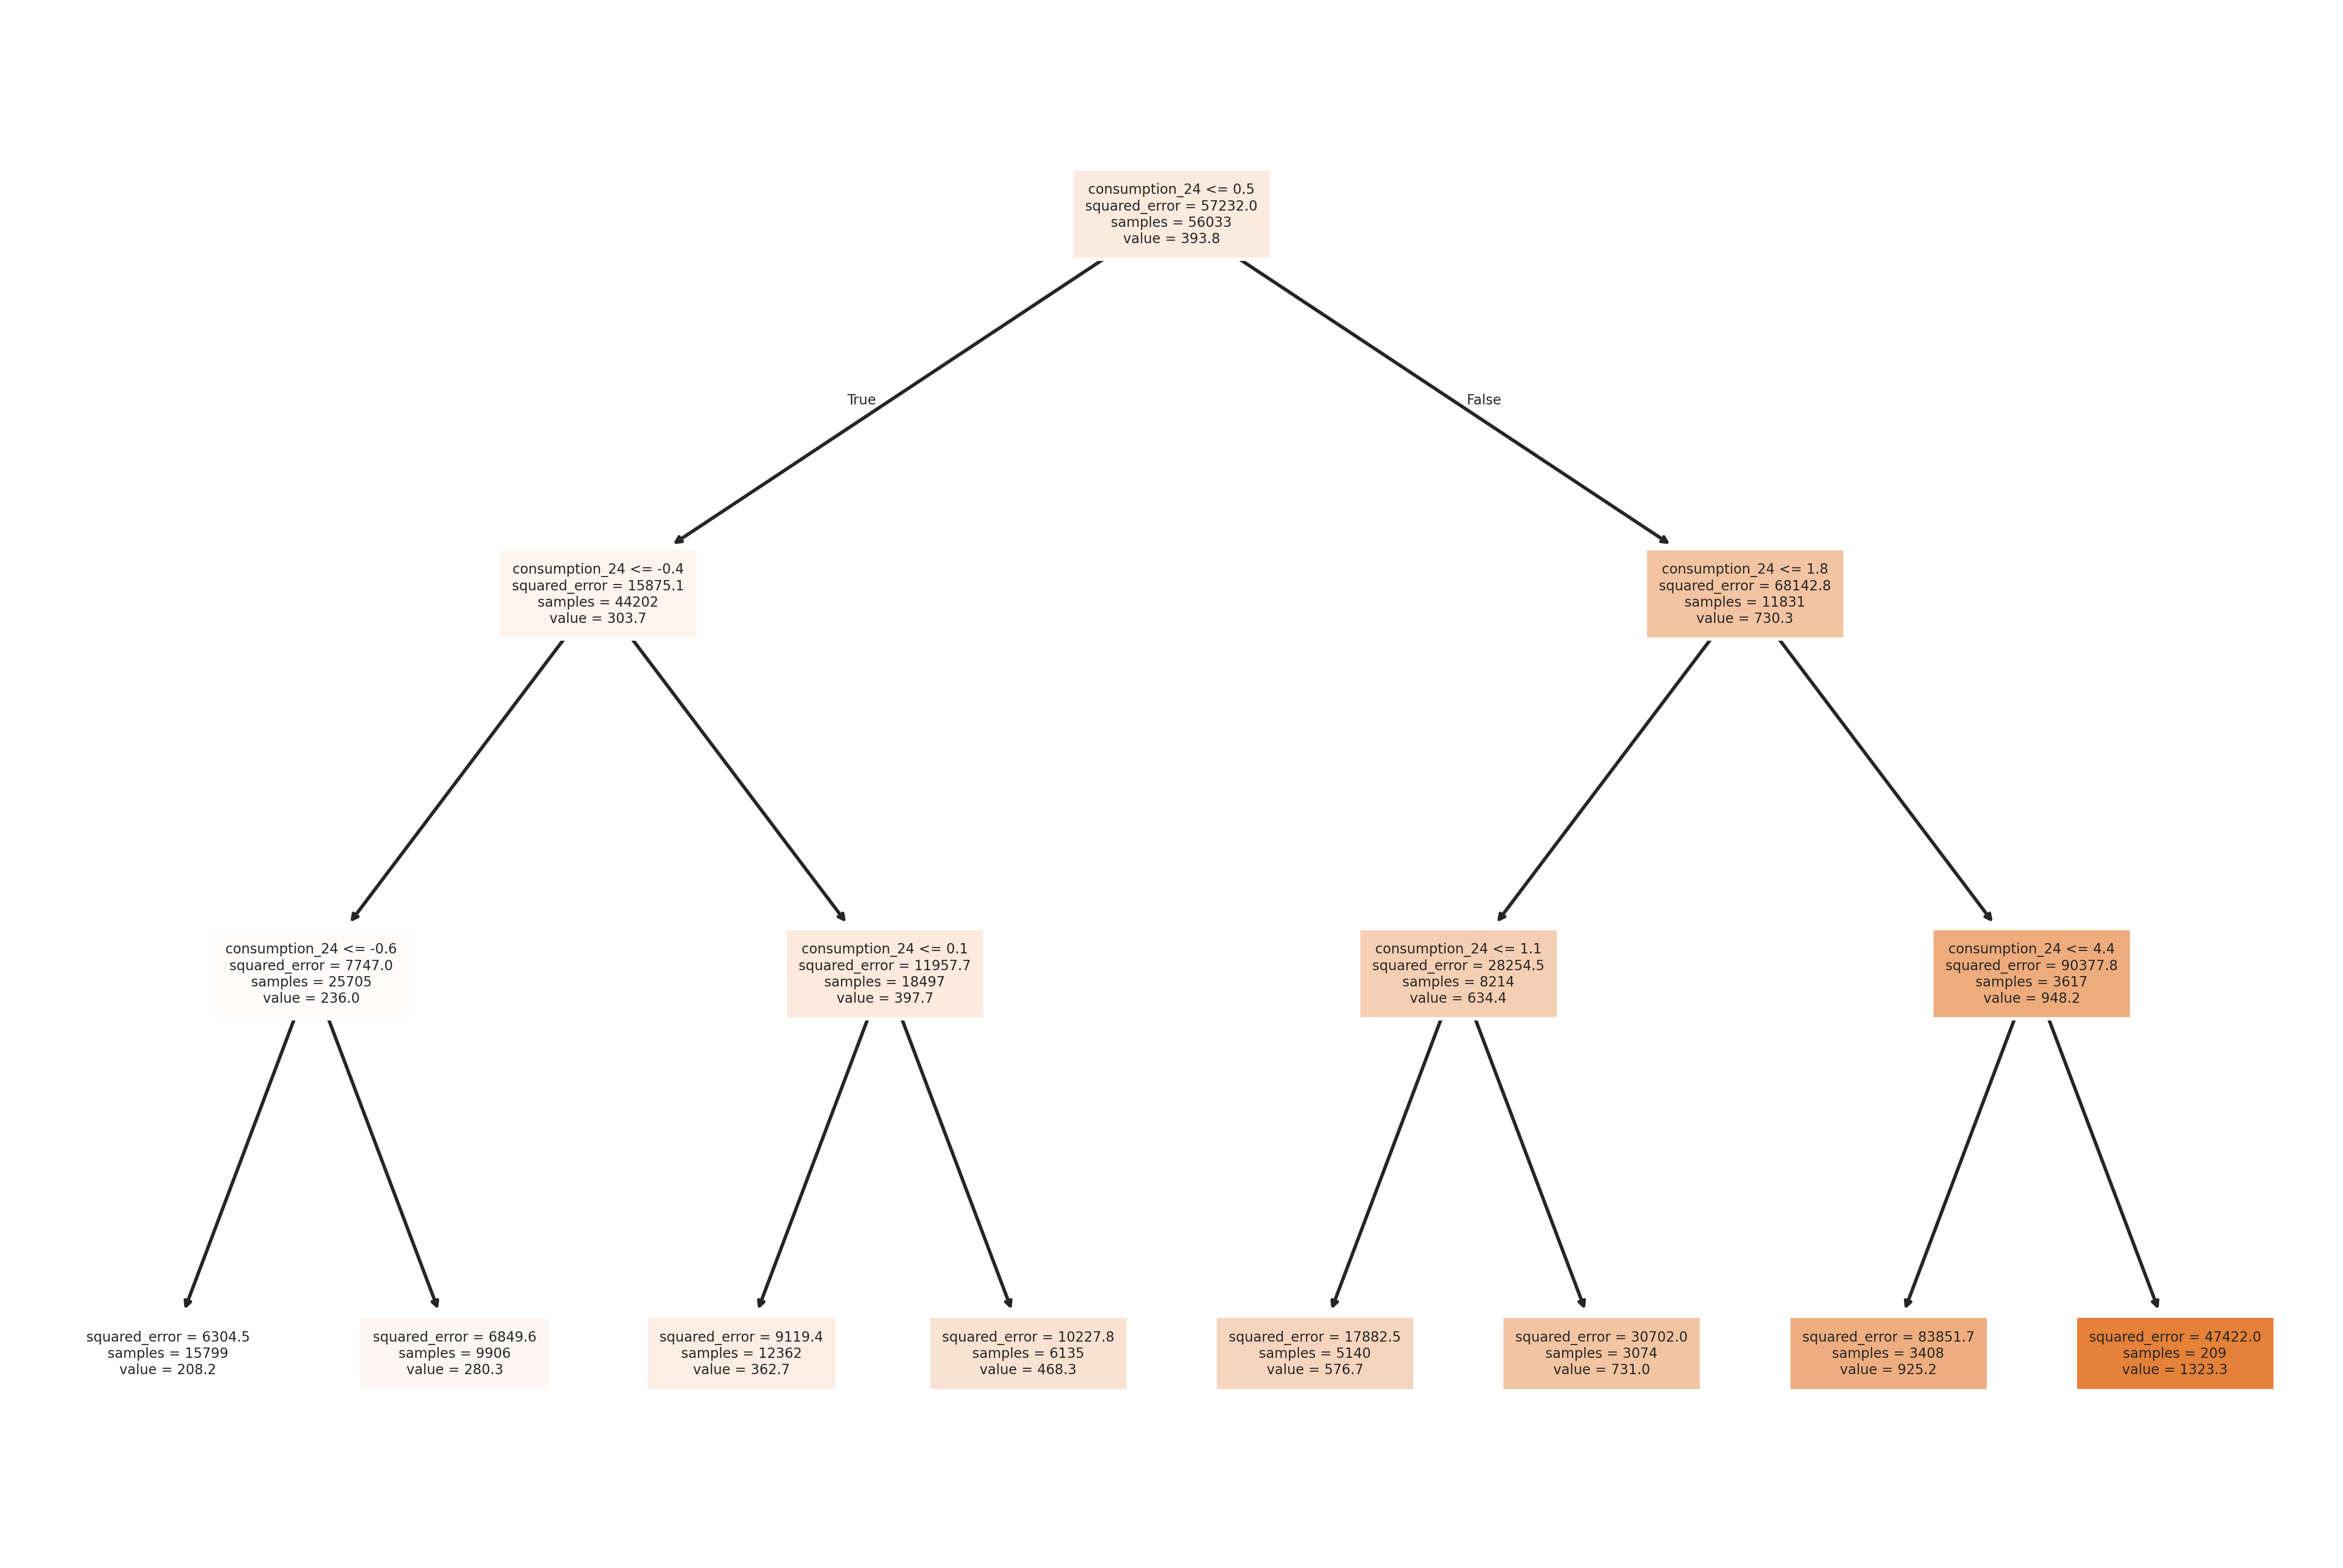

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dt_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_reg.fit(X_train_prepd, y_train)
plt.figure(dpi=500) # Makes the figure a little larger, easier to read.
plot_tree(dt_reg, filled=True, feature_names=list(X_train_prepd.columns), precision=1, fontsize=4)

Using a basic Decision Tree Regressor and showing a graphical representation, we see that it values the consumption_24 variable the most.

Let's see how the basic model does before hyperparameter tuning.

In [ ]:
dt_reg_scores = cross_val_score(dt_reg, X_train_prepd, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f'Training Decision Tree RMSE: {(-dt_reg_scores).mean()}')
dt_reg_r2 = cross_val_score(dt_reg, X_train_prepd, y_train, scoring = "r2", cv=3)
print(f'Training Decision Tree Regression R2: {(dt_reg_r2).mean()}')
#print(f'Target Variable Training Std. Deviation: {y_train.std()}')

Decision Tree RMSE: 121.5734668713194
Decision Tree Regression R2: 0.7416657555504473
Target Variable Training Std. Deviation: 239.23424335471702


Without manipulating hyperparameters, Decision Trees seem to perform similarly to Linear Regression by RMSE and R2 score. We will use Random Search to identify better hyperparameters.

### Hyperparameter Tuning on Decision Tree Regressor using Random Seach

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

dt_reg = Pipeline([('prep',prep_pipeline),('dt_reg',DecisionTreeRegressor())])
#parameter distributions
param_dist = {
    'dt_reg__max_depth': randint(2, 30),
    'dt_reg__min_samples_split': randint(2, 20),
    'dt_reg__min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=dt_reg,
    param_distributions=param_dist,
    n_iter=100,  #random combinations to try
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
rs_results = pd.DataFrame(random_search.cv_results_)
rs_results.sort_values(by = 'rank_test_score', ascending = True, inplace=True)
rs_results[["param_dt_reg__max_depth", "param_dt_reg__min_samples_leaf","param_dt_reg__min_samples_split",
            "mean_test_score","rank_test_score"]].head(5)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


param_dt_reg__max_depth  param_dt_reg__min_samples_leaf  \
18                       18                               4   
14                       19                               4   
42                       16                               3   
45                       14                               4   
59                       18                               5   

    param_dt_reg__min_samples_split  mean_test_score  rank_test_score  
18                               19         0.812289                1  
14                               15         0.811798                2  
42                                8         0.811797                3  
45                               14         0.811402                4  
59                               18         0.810604                5

Our Random Search suggests a max_depth of 18, min_samples_leaf of 4, and min_samples_split of 19 are the best choices for hyperparameters. We can evaluate the RMSE below.

In [ ]:
dt_reg_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f'Training Decision Tree RMSE (Best Estimator): {(-dt_reg_scores).mean()}')
dt_reg_r2 = cross_val_score(random_search.best_estimator_, X_train, y_train, scoring = "r2", cv=3)
print(f'Training Decision Tree Regression R2 (Best Estimator): {(dt_reg_r2).mean()}')
#print(f'Target Variable Training Std. Deviation: {y_train.std()}')

Decision Tree RMSE: 103.58888631854046
Decision Tree Regression R2: 0.8122869904848966
Target Variable Training Std. Deviation: 239.23424335471702


RMSE dropping by 15 kilowatts is significant. To see if we can push the Decision Tree further, we try cost-complexity pruning next.

### Cost Complexity Pruning on Decision Tree Regressor

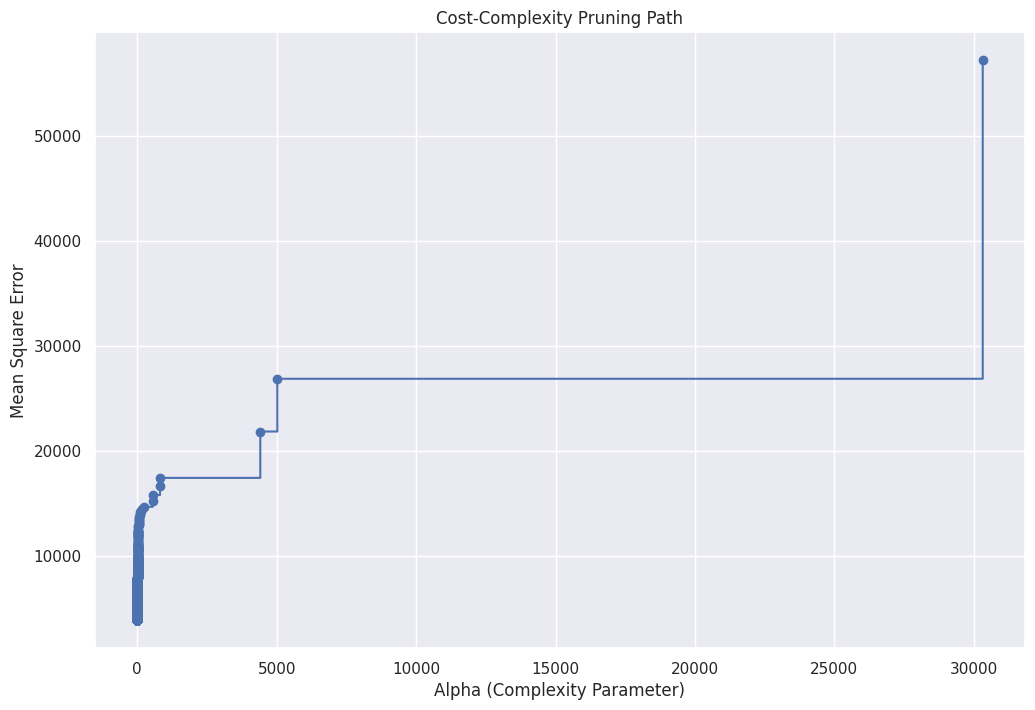

In [ ]:
dt_reg_full = DecisionTreeRegressor(random_state=42, max_depth = 16,
                                    min_samples_leaf=3,min_samples_split=8).fit(X_train_prepd, y_train)

path = dt_reg_full.cost_complexity_pruning_path(X_train_prepd, y_train)
dt_reg_ccp_alphas, dt_reg_impurities = path.ccp_alphas, path.impurities

plt.plot(dt_reg_ccp_alphas, dt_reg_impurities, marker='o', drawstyle='steps-post')
plt.xlabel('Alpha (Complexity Parameter)')
plt.ylabel('Mean Square Error')
plt.title('Cost-Complexity Pruning Path')
plt.show()

Things are going to be computationally expensive if we use all possible alpha values (2982), so we truncate the list of alphas below and use that for our Randomized Search.

In [ ]:
dt_reg_ccp_alphas_truncated = dt_reg_ccp_alphas[::10]
alpha_param_dist = {'ccp_alpha':dt_reg_ccp_alphas_truncated}
ccp_random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=42),alpha_param_dist,n_iter=20,cv=3,scoring='r2')
ccp_random_search.fit(X_train_prepd, y_train)

ccp_grid_results = pd.DataFrame(ccp_random_search.cv_results_)
ccp_grid_results.sort_values(by='rank_test_score', ascending=True, inplace=True)
ccp_grid_results.head(5)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7        5.744404      0.707565         0.006573        0.000978   
0        5.742560      0.624516         0.006938        0.000995   
17       5.724454      0.798375         0.008311        0.001163   
11       5.745325      0.366385         0.007351        0.001547   
9        5.709390      0.683356         0.007959        0.000885   

    param_ccp_alpha                             params  split0_test_score  \
7          5.121465  {'ccp_alpha': 5.1214650036494405}           0.788050   
0          3.515954  {'ccp_alpha': 3.5159541627189697}           0.786167   
17         1.872103  {'ccp_alpha': 1.8721034301545636}           0.780871   
11         1.749039  {'ccp_alpha': 1.7490393528206951}           0.780591   
9          0.736488  {'ccp_alpha': 0.7364881559835392}           0.776165   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
7            0.782231           0.815020         0.795100        0.014284   
0            0.778790           0.813850         0.792936        0.015092   
17           0.776376           0.806696         0.787981        0.013360   
11           0.775770           0.807299         0.787887        0.013867   
9            0.767184           0.803057         0.782135        0.015241   

    rank_test_score  
7                 1  
0                 2  
17                3  
11                4  
9                 5

With cost-complexity pruning on a truncated list of the potential alpha values, we get a similar R2 score to that of the hyperparameters found through Randomized Search.

It is worth comparing how these two perform on the test data, to see if overfitting has occurred.

In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score
y_pred = ccp_random_search.best_estimator_.predict(X_test_prepd)
print(f'Test CCP RMSE: {root_mean_squared_error(y_test, y_pred)} \nTest CCP R2: {r2_score(y_test, y_pred)}')

y_pred2 = random_search.best_estimator_.predict(X_test)
print(f'\nTest Max_Depth RMSE: {root_mean_squared_error(y_test, y_pred2)} \nTest Max_Depth R2: {r2_score(y_test, y_pred2)}')

CCP RMSE: 100.34855461763937 
CCP R2: 0.8240275503336955

Max_Depth RMSE: 95.22451598147765 
Max_Depth R2: 0.8415398785048771


The hyperparameter tuning on max_depth does marginally better than the cost-complexity pruning done earlier. Now, we move to Random Forest Regression.

## **Random Forest**


### Random Forest Regressor

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf_pipeline = Pipeline([('prep',prep_pipeline),('rf',RandomForestRegressor())])
rand_cv_rmses = cross_val_score(rf_pipeline, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Training Random Forest RMSE: {-rand_cv_rmses.mean():.0f}")

Average Random Forest Cross-Validation RMSE: 94


In [ ]:
rand_cv_r2 = cross_val_score(rf_pipeline, X_train, y_train,
                              scoring="r2", cv=3)
print(f"Training Random Forest R2: {rand_cv_r2.mean():.2f}")

Average Random Forest Cross-Validation R2: 0.85


Upon cross-validation, we find that the average RMSE on the training dataset is 94 and the average R2 is at .85. Let's fit the model and see how it does without tuned hyperparameters on the test set.

In [ ]:
rf_pipeline.fit(X_train, y_train)  # Fit the pipeline to training data
y_pred = rf_pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE : {test_rmse:.2f}')

test_r2 = r2_score(y_test, y_pred)
print(f'Test Random Forest R2: {test_r2:.2f}')



Test R2: 0.89
Test RMSE : 80.85


On the test set, it performs suprisingly well with an RMSE of 80.85 and an R2 of .89.

In an attempt to optimize the model, we perform another Randomized Search on the max_depth, n_estimators, and min_samples_leaf hyperparameters. Because Random Forest models can take a long time to fit, we limit the iterations to 5 and keep the ranges of our parameter distribution short.

### Hyperparameter Tuning on Random Forest Regressor using Random Search

In [ ]:
param_dist = {
    'max_depth': np.arange(1, 20),
    'n_estimators': np.arange(100, 500, 100),
    'min_samples_leaf': np.arange(1, 20)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=7,
    scoring='neg_root_mean_squared_error',
    cv=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_prepd, y_train)

print("Best Parameters:", random_search.best_params_)

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = random_search.best_estimator_.predict(X_test_prepd)

test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test Random Forest RMSE (with Hyperparameter Tuning): {test_rmse:.2f}")
print(f"Test Random Forest R2 (with Hyperparameter Tuning): {test_r2:.2f}")


Best Parameters: {'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': 18}
Test R^2: 0.88
Test RMSE: 82.30


The Random Forest with hyperparameters tuned performed similarly on the test data, though a little worse by the RMSE metric.

To compare with a different model, we move on to using KNN Regressor.

## **K Nearest Neighbors**

### K Neighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
X_train_prepd = prep_pipeline.fit_transform(X_train)
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_prepd, y_train)

knn_rmse_scores = cross_val_score(knn_reg, X_train_prepd, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f'Training KNN RMSE: {(-knn_rmse_scores).mean()}')

knn_r2_scores = cross_val_score(knn_reg, X_train_prepd, y_train, scoring="r2", cv=3)
print(f'Training KNN Regression R²: {knn_r2_scores.mean()}')

#print(f'Target Variable Training Std. Deviation: {y_train.std()}')


KNN RMSE: 132.45828099981938
KNN Regression R²: 0.6934168914982782
Target Variable Training Std. Deviation: 239.23424335471702


KNN seems to do notably worse than the Decision Tree and Random Forest Models. Perhaps it can catch up with some hyperparameter tuning?

### Hyperparameter Tuning on K Neighbors Regressor using Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_neighbors': np.arange(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_reg = KNeighborsRegressor()

knn_random_search = RandomizedSearchCV(
    knn_reg,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=2,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [ ]:
knn_random_search.fit(X_train_prepd, y_train)

# best parameters and the corresponding score
print("Best Parameters:", knn_random_search.best_params_)
print("Training KNN RMSE (Hyperparameter tuning best score):", -knn_random_search.best_score_)

# cross-validation R2
best_knn = knn_random_search.best_estimator_
knn_r2_scores = cross_val_score(best_knn, X_train_prepd, y_train, scoring="r2", cv=3)
print(f'Training KNN Regression R2 (Hyperparameter tuning best score): {(knn_r2_scores.mean())}')


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 14}
Best RMSE: 128.71724681119275
Best KNN Regression R2: 0.7167955196022491


The hyperparameter search marginally improves RMSE and R2, but not enough for KNN to contend with other models. Out of curiosity, let's see how it performs on the test data before finishing with the Voting Regressor.

In [ ]:
X_test_prepd = prep_pipeline.transform(X_test)
best_knn = KNeighborsRegressor(
    weights='distance',
    p=2,
    n_neighbors=14
)

X_train_prepd = prep_pipeline.fit_transform(X_train)
best_knn.fit(X_train_prepd, y_train)

y_test_pred = best_knn.predict(X_test_prepd)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("Test KNN RMSE (Best_Estimator):", rmse_test)
print("Test KNN R2 (Best_Estimator):", r2_test)

Test Root Mean Squared Error (RMSE): 125.98859475720053
Test R2 (Coefficient of Determination): 0.7226137682484759


Using the best parameters for KNN model that were discovered during random search lead to a test RMSE of 125kw which is slightly better than the RMSE we see for our train error (difference of 3kw). However, it does not outperform the results we got using Random Forest Regressor (difference of 31kw).

Let's see if using a different ensemble model -voting regressor- can improve the error score:

## **Voting Ensemble**

### Voting Regressor

Briefly, we will try the Voting Regressor to combine models to see if it yields better results than the models' individual results.

### Voting Regressor Ensemble for KNeighborsRegressor and RandomForestRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor
knn_reg = KNeighborsRegressor(weights='distance', p=2, n_neighbors=14)

rf_reg = RandomForestRegressor()

voting_reg = VotingRegressor([('knn',knn_reg),('rf',rf_reg)])


vote_pipe = Pipeline([('prep',prep_pipeline),('voting_reg',voting_reg)])

vote_pipe.fit(X_train, y_train)
y_pred = vote_pipe.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test Voting Regressor RMSE : {test_rmse:.2f}')
test_r2 = r2_score(y_test, y_pred)
print(f'Test Voting Regressor R2: {test_r2:.2f}')

Test R2: 0.84
Test RMSE : 97.16


### Voting Regressor Ensemble for RidgeRegression and RandomForestRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor
ridge_reg = Ridge(alpha=10)

rf_reg = RandomForestRegressor()

voting_reg = VotingRegressor([('ridge_poly',ridge_reg),('rf',rf_reg)])


vote_pipe = Pipeline([('prep',prep_pipeline),('voting_reg',voting_reg)])

vote_pipe.fit(X_train, y_train)
y_pred = vote_pipe.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test Voting Regressor RMSE : {test_rmse:.2f}')
test_r2 = r2_score(y_test, y_pred)
print(f'Test Voting Regressor R2: {test_r2:.2f}')

Test R2: 0.84
Test RMSE : 95.95


Applying the voting pipeline seems to do worse than Random Forest alone. It seems at least in the case of the dataset we have used, Random Forest is the best model in minimizing error in its' predictions.

# **Challenges and Next Steps**

Our dataset had a limited number of features, most being weather-related. Weather data alone was insufficient to accurately predict electricity consumption in a building. To address this, we performed extensive feature engineering, creating additional columns to enhance model performance.
Particular attention was required during the creation of the lagging feature, since we needed to avoid any possible data leakage while carrying out the same.
Additionally, properly encoding and ensuring that the model valued categorical features appropriately provide to be challenging and required several iterations before the model could effectively leverage them.

# **Conclusion**



The project demonstrates that predictive modeling can be a useful tool for estimating residential electricity consumption. Many of the models used did result in significant results with R2 greater than 0.75 which indicates that the model relatively effective at predicting the target variable, as it captures most of the underlying patterns, making them valuable for tasks such as forecasting electricity costs or assisting service providers in balancing grid load.

Among the tested models, Random Forest emerged as the most effective, successfully handling the nonlinear relationships in the data and achieving the lowest RMSE (80.70kw) and highest \(R^2\) score (0.88). In contrast, simpler models like Linear Regression and KNN struggled with interpreting the complex interactions between weather, time, and consumption patterns.

The primary challenges involved the limited number of features in the dataset and the careful engineering of lagging variables to avoid data leakage. Despite these obstacles, the feature engineering and preprocessing steps were taken in such a way that significantly enhanced model performance.

Overall, the Random Forest model can be considered a reliable aid for estimating electricity consumption, though further refinements—such as incorporating additional features or leveraging advanced ensemble techniques—could enhance its accuracy further.